In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from osgeo import gdal
import numpy as np
import rasterio as rio

In [2]:
from autoRIFT import autoriftcore
from geogrid import GeogridOptical

In [3]:
def rio_read(path):
    with rio.open(path) as ds:
        crs = ds.crs
        gtfm = ds.transform
        data = ds.read(1)
    return data, crs, gtfm

In [4]:
def loadProductOptical(file_m, file_s):
    '''
    Load the product using Product Manager.
    '''
    obj = GeogridOptical()

    x1a, y1a, xsize1, ysize1, x2a, y2a, xsize2, ysize2, trans = obj.coregister(file_m, file_s)

    DS1 = gdal.Open(file_m)
    DS2 = gdal.Open(file_s)

    I1 = DS1.ReadAsArray(xoff=x1a, yoff=y1a, xsize=xsize1, ysize=ysize1)[1500:2000,500:1500]
    I2 = DS2.ReadAsArray(xoff=x2a, yoff=y2a, xsize=xsize2, ysize=ysize2)[1500:2000,500:1500]

    I1 = I1.astype(np.float32)
    I2 = I2.astype(np.float32)
    
    I1[np.isnan(I1)] = 0
    I2[np.isnan(I2)] = 0

    DS1=None
    DS2=None

    return I1, I2

I1,I2 = loadProductOptical('s2_l2_R129_T60HUB_20181018.tif', 's2_l2_R129_T60HUB_20210902.tif')

In [4]:
ref, crs, gtfm = rio_read('20170911_panchromatic_AnalyticMS_SR_clip.tif')
sec, _, _ = rio_read('20200903_panchromatic_AnalyticMS_SR_clip.tif')

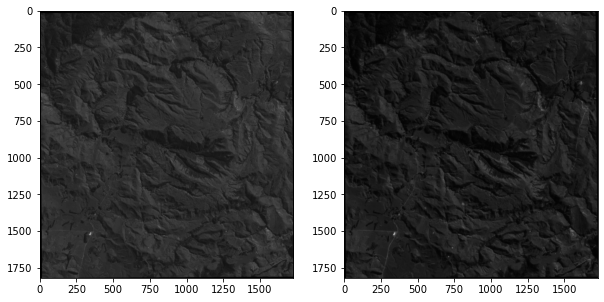

In [5]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(ref,cmap='gray')
ax2.imshow(sec,cmap='gray')

## Inputs
**I1**  reference image (extracted image patches defined as "source")

**I2**  secondary image (extracted image patches defined as "template"; displacement = motion vector of I2 relative to I1 which should be acquired earlier in our convention)

**xGrid** [units = integer image pixels]  horizontal reference image pixel index at each grid point

**yGrid**  [units = integer image pixels]  vertical reference image pixel index at each grid point
(if xGrid and yGrid not provided, a regular grid spanning the entire image will be automatically set up, which is similar to the conventional ISCE module, "ampcor" or "denseampcor")

**Dx0**  [units = integer image pixels]  horizontal "downstream" search location (that specifies the horizontal pixel displacement of the template's search center relative to the source's) at each grid point

**Dy0**  [units = integer image pixels]  vertical "downstream" reach location (that specifies the vertical pixel displacement of the template's search center relative to the source's) at each grid point
(if Dx0 and Dy0 not provided, an array with zero values will be automatically assigned and there will be no offsets of the search centers)

**ChipSizeMinX** [units = integer image pixels]  Minimum size (in horizontal direction) of the template (chip) to correlate (default = 32; could be scalar or array with same dimension as xGrid)

**ChipSizeMaxX** [units = integer image pixels]  Maximum size (in horizontal direction) of the template (chip) to correlate (default = 64; could be scalar or array with same dimension as xGrid)

**ChipSize0X** [units = integer image pixels]  Minimum acceptable size (in horizontal direction) of the template (chip) to correlate (default = 32)

**GridSpacingX** [units = integer image pixels]  Grid Spacing (in horizontal direction) (default = 32; note GridSpacingX can be smaller than ChipSize0X leading to dependent chips)

**ScaleChipSizeY** [unitless; integer data type]  Scaling factor to get the vertical chip size in reference to the horizontal size (default = 1)

**SearchLimitX** [units = integer image pixels]  Range or limit (in horizontal direction) to search for displacement in the source (default = 25; could be scalar or array with same dimension as xGrid; when provided in array, set its elements to 0 if no search is desired in certain areas)

**SearchLimitY** [units = integer image pixels]  Range or limit (in vertical direction) to search for displacement in the source (default = 25; could be scalar or array with same dimension as xGrid; when provided in array, set its elements to 0 if no search is desired in certain areas)

**SkipSampleX** [units = integer image pixels] Number of samples to skip between search windows in horizontal direction if no grid specified by the user (default = 32)

**SkipSampleY** [units = integer image pixels]  Number of lines to skip between search windows in vertical direction if no grid specified by the user (default = 32)

**minSearch** [units = integer image pixels]  Minimum search range/limit (default = 6)

In [21]:
from autoRIFT import autoRIFT

In [194]:
# intizialize
obj = autoRIFT()

# set imagery
obj.I1 = ref
obj.I2 = sec

# Sampling
obj.SkipSampleX = 16
obj.SkipSampleY = 16

# Chip size
obj.ChipSizeMinX = 64
obj.ChipSizeMaxX = 64
obj.ChipSize0X = 64
obj.ScaleChipSizeY = 1

# Search Area
obj.SearchLimitX = 10
obj.SearchLimitY = 10
obj.minSearch = 0

# Result grid
xVals = np.arange(obj.SkipSampleX,n-obj.SkipSampleX,obj.SkipSampleX)
yVals = np.arange(obj.SkipSampleY,m-obj.SkipSampleY,obj.SkipSampleY)

ncol = int(xVals.shape[0])
nrow = int(yVals.shape[0])

xGrid = np.repeat(np.reshape(xVals,(1,ncol)),nrow,axis=0)
yGrid = np.repeat(np.reshape(yVals,(nrow,1)),ncol,axis=1)

obj.xGrid = xGrid
obj.yGrid = yGrid

In [195]:
xGrid.shape, (ref.shape[0]/16,ref.shape[1]/16)

((112, 106), (113.75, 108.0))

In [137]:
%%time
obj.runAutorift()

CPU times: user 5.04 s, sys: 0 ns, total: 5.04 s
Wall time: 5.04 s


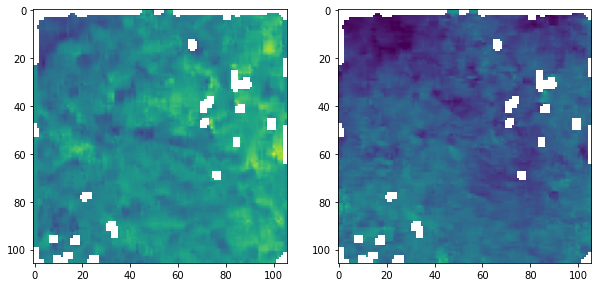

In [138]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
dx = ax1.imshow(obj.Dx,vmin=-3,vmax=3)
dx = ax2.imshow(obj.Dy,vmin=-3,vmax=3)
# f.colorbar(dy,ax=ax2)

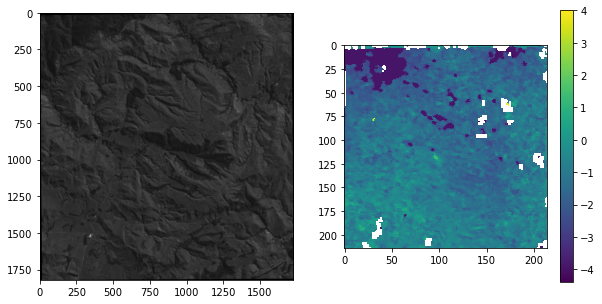

In [112]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
img = ax1.imshow(ref,cmap='gray')
dy = ax2.imshow(obj.Dy)
f.colorbar(dy,ax=ax2)

## compare to cosicorr

In [140]:
cosi_dx, _, _ = rio_read('cosicorr_20170911T000000_20200903T000000_EWOffset.tif')
cosi_dy, _, _ = rio_read('cosicorr_20170911T000000_20200903T000000_NSOffset.tif')

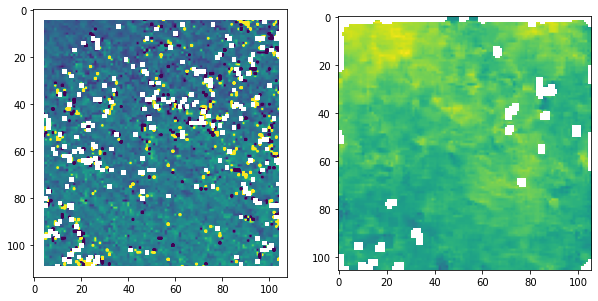

In [168]:
%matplotlib inline
import matplotlib.pyplot as plt

f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
cosi = ax1.imshow(cosi_dy,vmin=-10,vmax=10)
rift = ax2.imshow(obj.Dy*-3,vmin=-10,vmax=10)

In [164]:
gtfm

Affine(3.0, 0.0, 418203.0,
       0.0, -3.0, 5508564.0)

In [156]:
obj.Dy - np.nanmean(obj.Dy)

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ..., -0.21717298,
                nan,         nan],
       ...,
       [        nan,         nan,  0.22032702, ...,  0.15782702,
                nan,         nan],
       [        nan,         nan,  0.845327  , ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)